<a href="https://colab.research.google.com/github/guthi1/technical-analysis-trading-dumpster-fire/blob/main/Article_En.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading Places: When Technical Analysts Meet Artificial Intelligence

By:  Guillaume Thibault - g.thibault@polymtl.ca

Code: [See full notebook](https://github.com/guthi1/technical-analysis-trading-dumpster-fire/blob/main/notebook.ipynb).  

The Efficient Market Hypothesis, developed by Eugene Francis Fama, states that the prices of financial securities represent all available information at all times, making it impossible to buy an undervalued stock or sell an overvalued stock. In this vein, under the least restrictive market efficiency assumption, prices reflect all available past information, making technical analysis useless for predicting future price changes. 

Technical analysis is a method of financial analysis that focuses on studying the price history and trading volumes of an asset, such as stocks, currencies, commodities, bonds, etc. This method is based on the idea that market trends, patterns and past behavior can be used to predict future price movements.

Technical analysts use charts to represent historical price patterns and technical indicators to assess market strength or weakness. These indicators include moving averages, oscillators, trading volumes, support and resistance levels, and other measures that help identify trends and patterns in historical data.

In order to test the hypothesis of weak financial market efficiency, let's try to get out technical analysis signals.

## A use case for artificial intelligence? 

Knowing that the main principle is signal extraction from these measurements, it may be interesting to try to use artificial intelligence tools to automate the technical analysis, instead of using my weak knowledge in the field. These machine learning algorithms can be used to identify patterns in historical data that are not easily identifiable by humans, or to detect anomalies in trends that might indicate changes in market direction.

The use of artificial intelligence in technical analysis can help automate certain tasks such as finding buy and sell signals, identifying support and resistance levels, monitoring trading volumes, etc. This can help traders and investors make faster and more accurate decisions based on more complete and reliable data.

## Disclamer

It is important to note that using artificial intelligence to make buying and selling decisions in the financial markets carries enormous risks and can result in significant losses. Machine learning algorithms cannot predict market fluctuations with certainty and human supervision is necessary to avoid mistakes or misinterpretation of data. 

That being said, this article does not follow this recommendation and instead aims to explore the possibility of using artificial intelligence to perform technical analysis in order to execute buy and sell orders in the financial markets. 

In other words: Do not reproduce at home ;)

## The project

The idea is to try out image analysis models having the translation invariance property on technical graphs, with the aim that machine learning techniques learn technical analysis signals directly. The article is dedicated to a first proof of concept in the subject.


## The Data

To get started in a relatively simple way, let's just use candlestick charts. This type of chart represents the price movements of a financial asset. Each candlestick represents the opening price, closing price, and the highest and lowest prices during the period under consideration. This type of chart allows you to quickly visualize the price movements of an asset and detect trends or patterns in the historical data.

In our case, let's start by using a 2-minute interval per candlestick and compose charts with 30 candlesticks corresponding to 60-minute intervals per chart. Since we are going to use deep learning techniques on images, it is important to remove any information that could be used by the model to make its prediction that is not a candlestick. The following graph corresponds to an image that the model will have to analyze to extract a signal.


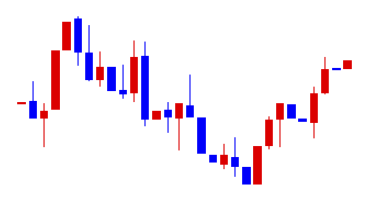

Knowing that these images will be used for training the model, let's simplify the graphics to reduce the memory and computing power needed for training. To do this, let's lower the resolution of the image, without losing information, by increasing the size of the bands and by using several colors to distinguish the different parts of the candles.

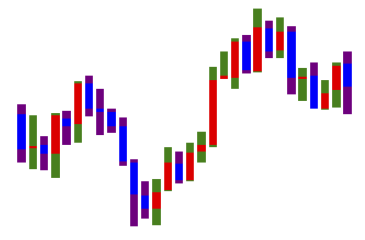

## Create Dataset

The code for the data processing can be found in the [full notebook](https://github.com/guthi1/technical-analysis-trading-dumpster-fire/blob/main/notebook.ipynb). 

Some additional details:
* Source - yfinance python library
* Tickers - 186 tickers with the highest transaction volume for February 17th 2023

* Training dataset: 4464 images
* Validation dataset: 1116 images

Date range (will automatically adjuste to the last 5 trading day): 
* 2023-02-13 10:30:00-05:00 to 2023-02-17 15:30:00-05:00
* Date threshold for the 20% of the validation set: > 2023-02-16 19:18:00-05:00


Important step: Look at the distribution of our data to see if it is not too unbalanced

| Value         | Price     | 
|--------------|-----------|
| Hold | 2121      |
| Buy      | 2080  | 
| Sel;      | 1379 | 


## DataLoader

Let's create a data loader for the dataset we created

In [ ]:
class TechnicalAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, data, chart_dir, transform=None):
        self.df = data
        self.img_dir = chart_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]["filename"])
        image = read_image(img_path)
        image = image / 255
        label = self.df.iloc[idx]["action"]
        if self.transform:
            image = self.transform(image)
        return image, label

Now that we have our dataset, we will need to split it in a training and validation set and we will need a data loader to be able to have minibatch.

In [ ]:
def train_test_split_by_date(df, frac=0.2, debug=True):
    begening = df.iloc[0].date
    end = df.iloc[-1].date

    threshold = begening + (end - begening) * (1-frac)

    if debug: print(f"Date range: {begening} - {end}")
    if debug: print(f"Treshold date for {frac}% valid: {threshold}")

    train = df[df.date.between(begening, threshold)]
    valid = df[df.date.between(threshold, end)]

    if debug: print(f"train: {len(train)}")
    if debug: print(f"valid: {len(valid)}")

    return train, valid

In [ ]:
train_dataset, test_dataset = train_test_split_by_date(dataset)
resize_transform = transforms.Resize(size=(64, 64))
train_technical_analysis_dataset = TechnicalAnalysisDataset(train_dataset, DATA_CANDLE, transform=resize_transform)
test_technical_analysis_dataset = TechnicalAnalysisDataset(test_dataset, DATA_CANDLE, transform=resize_transform)

train_loader = torch.utils.data.DataLoader(
    train_technical_analysis_dataset, batch_size=64, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
      test_technical_analysis_dataset, batch_size=64, shuffle=False, num_workers=2
)

Date range: 2023-02-13 10:30:00-05:00 - 2023-02-17 15:30:00-05:00
Treshold date for 0.2% valid: 2023-02-16 19:18:00-05:00
train: 4464
valid: 1116


torch.Size([4, 64, 64])
torch.Size([64, 64, 4])
0


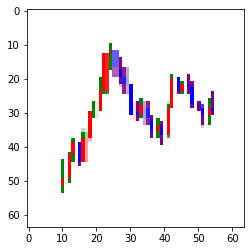

In [ ]:
# Sanity check
img, label = train_technical_analysis_dataset.__getitem__(1)
print(img.shape)
img = img.permute(1, 2, 0)
print(img.shape)
print(label)
plt.imshow(img)
plt.show()

## The model 

The chosen model is a convolutional neural network (CNN) model which is a deep neural network architecture used in computer vision tasks. Convolution filters are a key component of CNNs. They are filters that scan the image to extract important features.

Convolution filters are applied to every part of the image and are used to extract features such as edges, textures and shapes. Convolution filters are defined by their dimensions (width and height) and depth. During training, the CNN automatically adjusts the values of the convolution filters to optimize the performance of the classification or regression task.


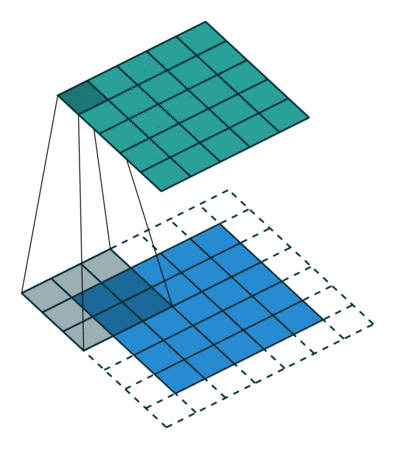

The model used will be Restnet-18, a deep convolutional neural network (CNN) model, developed by Kaiming He and several other researchers at Microsoft Research originally published in the paper "Deep Residual Learning for Image Recognition" released in 2015.  

* Reference: https://arxiv.org/abs/1512.03385

This type of architecture is very popular because of the use of residual connections, a method used to solve the problem of degradation of the network accuracy when the network depth increases by adding direct connections that bypass several convolution layers. These residual connections allow the network to retain previously learned information and thus facilitate the learning of new image representations.

### MLP

For reference, to demonstrate the potential utility of this type of model, let us establish a benchmark against which to compare the CNN model. We will use a simple dense neural network (MLP) model, in which each neuron is connected to each pixel in the image, as follows:

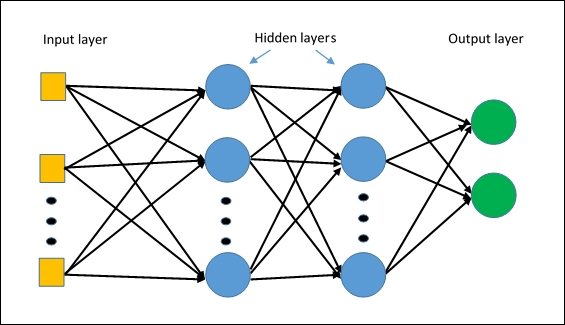

In [ ]:
from torch.nn.modules.dropout import Dropout
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4*64*64, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(512, 254),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(254, 3)
        )
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        out = self.model(x)
        return out

Now, the training of this model can be done in a few minutes. 

In [ ]:
import time
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 12

  mlp = MLP().to(device)
  nb_params = sum(p.numel() for p in mlp.parameters())
  print(mlp)
  print(f"Number of parameter: {nb_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters())

  tic = time.perf_counter()
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, mlp, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, mlp, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

  toc = time.perf_counter()
  print(f"Time to train {toc - tic:0.4f} seconds")

### Result

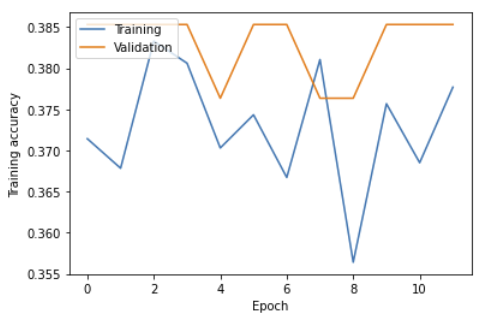

Looking at the preliminary results of such a model, we find that it is unable to detect patterns in the training and validation set. The results correspond to a completely random outcome.

### Resnet-18

After that, we can try with Resnet-18

In [ ]:
class ResidualBlock(nn.Module):
  """This class implements the Residual Block used in ResNet-18."""

  def __init__(self, in_channels, channels, conv_stride=1, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResidualBlock class.
    """
    super(ResidualBlock, self).__init__()

    self.in_channels = in_channels
    self.channels = channels
    self.conv_stride = conv_stride
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(in_channels, channels, 3, stride=conv_stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(channels)

    self.residual_connection = self.residual(in_channels, channels, conv_stride)

    # Initialize weights for conv1 and conv2
    if initialization == "xavier_normal":
      nn.init.xavier_normal_(self.conv1.weight)
      nn.init.xavier_normal_(self.conv2.weight)
    elif initialization == "xavier_uniform": 
      nn.init.xavier_uniform_(self.conv1.weight)
      nn.init.xavier_uniform_(self.conv2.weight)
    elif initialization == "kaiming_normal": 
      nn.init.kaiming_normal_(self.conv1.weight)
      nn.init.kaiming_normal_(self.conv2.weight)
    else:
      raise Exception("Invalid initialization")

  def activation(self, input):
    """
      Output: Result of activation function applied on input.
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def residual(self, in_channels, channels, conv_stride=1):
    """
      Output: Returns an nn.Sequential object which computes the identity function or downsamples
              followed by a BatchNorm2d.
    """
    layers = []
    if conv_stride != 1 or in_channels != channels:
      layers.append(nn.Conv2d(in_channels, channels, 1, stride=conv_stride, padding=0, bias=False))
      layers.append(nn.BatchNorm2d(channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    """
      Outputs: Returns the output of the forward pass of the block.
    """
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += self.residual_connection(identity)
    out = self.activation(out)

    return out

We can than create the model

In [ ]:
class ResNet18(nn.Module):
  """This class implements the ResNet-18 architecture from its components."""

  def __init__(self, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResNet18 class.
    """
    super(ResNet18, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str
    self.initialization = initialization

    self.conv1 = nn.Conv2d(4, 64, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._create_layer(64, 64) 
    self.layer2 = self._create_layer(64, 128, conv_stride=2)
    self.layer3 = self._create_layer(128, 256, conv_stride=2)
    self.layer4 = self._create_layer(256, 512, conv_stride=2)  
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(512, 3)
  
  def activation(self, input):
    """
      Output: Result of activation function applied on input.
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def _create_layer(self, in_channels, channels, conv_stride=1):
    """
      Outputs: Returns an nn.Sequential object giving a "layer" of the ResNet, consisting of 2 blocks each.
    """
    return nn.Sequential(
        ResidualBlock(in_channels, channels, conv_stride=conv_stride, activation_str=self.activation_str, initialization=self.initialization),
        ResidualBlock(channels, channels, conv_stride=1, activation_str=self.activation_str, initialization=self.initialization)
    )

  def get_first_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the first convolution layer.
    """
    return self.conv1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the last convolution layer.
    """
    return list(self.layer4.modules())[1].conv2.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      Outputs: Returns the output of the forward pass of the network.
    """
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.linear(out)

    return out

In [ ]:
# Parameter we will use
activation_str = "relu"
initialization = "xavier_normal"

In [ ]:
# Training
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model = ResNet18(
    activation_str=activation_str,
    initialization=initialization
  ).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())
  
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    # train_acc, train_loss = train_loop(epoch, model, train_cifar, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    # val_acc, val_loss = valid_loop(epoch, model, valid_cifar, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
     

## Results

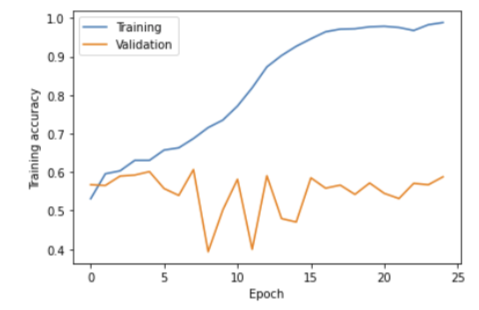ADD RESULT


Looking at the preliminary results of this experimentation, we can see that the Restnet-18 model succeeds in extracting patterns from the training set. The filters learned by the model also succeeded in detecting patterns in the training set and the predictions achieved an accuracy of about 50%. This result is promising. It is important to mention that the dataset was designed to be relatively realistic, i.e. training the model on a historical dataset and making the prediction on a dataset with a date that is later than the training dataset. The opposite case gives more impressive results of ~60%, but these are not realistic. 

## Conclusion

The use of deep learning model to learn technical chart signals proves to be a success. The model has proven to make the right decision between buying, doing nothing and selling at a accuracy of 50%, which is higher than random (33%) and always taking the dominant class (40%). The use of the model in practice remains inconceivable without using other analysis tools.

The results of the article impress me personally because I still have difficulty believing that signals can be hidden in historical data because the past is not a guarantee of the future. 

In reality, technical analysis is used by many traders and investors to make decisions to buy and sell assets. However, these methods do not take into account the fundamentals of a company or market, such as financial data, economic news, macroeconomic factors, etc. Therefore, technical analysis is often used in combination with fundamental analysis to get a more complete picture of the financial markets.


Some points that may be interesting to investigate further:
* Visualization of the filters learned by the model.
* Increase the volume of data used.
* Adding more fundamental analysis curves on the charts.
* Test different models, because only one was tested.